In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE               

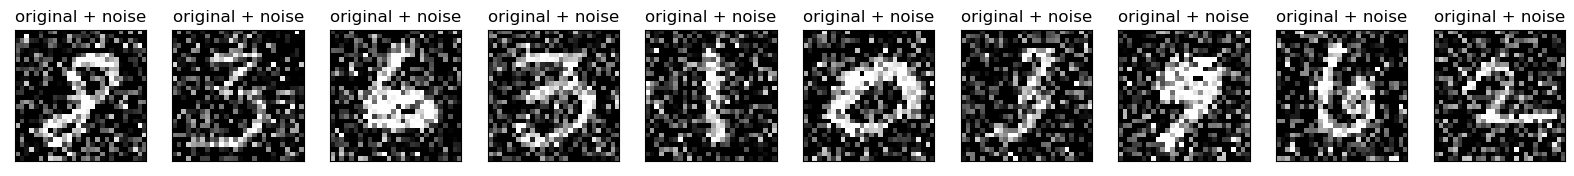

In [28]:
# load the dataset
(train_ds, val_ds) = tfds.load("mnist", split=["train", "test"], as_supervised=True)
og_val_ds = val_ds

# hyperparameters
noise_intensity = 0.4
batch_size = 128
latent_dim = 50

# preprocessing pipeline
def preprocess_data(data,ds_type='train'):
  data = data.map(lambda x, t: (tf.cast(x, tf.float32)/255.), num_parallel_calls=tf.data.AUTOTUNE)
  noisy_data = data.map(lambda x: tf.clip_by_value(x + tf.random.normal(data.element_spec.shape, mean = 0., stddev = noise_intensity), 0, 1), num_parallel_calls=tf.data.AUTOTUNE)
  data = tf.data.Dataset.zip((noisy_data, data))

  if ds_type == 'train':
    data = data.shuffle(1000)
  data = data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return data

train_ds, val_ds = preprocess_data(train_ds), preprocess_data(val_ds,ds_type = 'val')

# take some noisy imgs for visualization
for x, y in train_ds.take(1):  
    x_train_noisy = x.numpy()

for x, y in val_ds.take(1):  
    x_test_noisy = x.numpy()

# plot noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_train_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
# convolutional autoencoder model
class CAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CAE, self).__init__()

    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim)])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(49),
      tf.keras.layers.Reshape((7,7,1)),
      tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  @tf.function
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [30]:
autoencoder = CAE(latent_dim)

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

autoencoder.fit(train_ds, 
                epochs=10,
                shuffle=True,
                validation_data=val_ds)

Epoch 1/10
469/469 [==============================] - 12s 23ms/step - loss: 0.0540 - val_loss: 0.0282
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0245 - val_loss: 0.0222
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0212 - val_loss: 0.0200
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0196 - val_loss: 0.0187
Epoch 5/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 7/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 8/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 9/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 10/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0157 - val_l

79/79 [==============================] - 0s 3ms/step


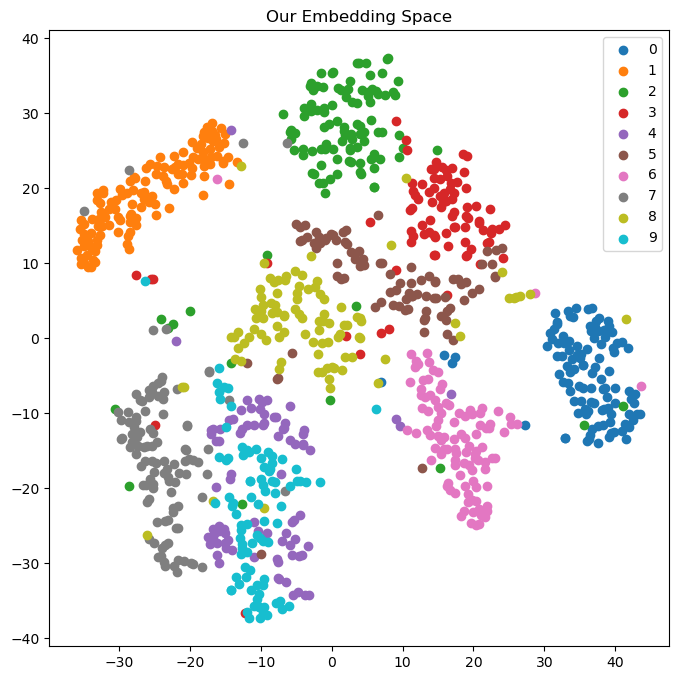

In [31]:
# get first 1000 embeddings
preds = autoencoder.encoder.predict(val_ds)[:1000]
# extract corresponding labels for plotting
labels = np.array([i.numpy() for i in list(og_val_ds.map(lambda x,y : y))])[:1000]
# reduce dimensionality with t-SNE for plotting 
embeddings_2d = TSNE(2).fit_transform(preds)

# plotting the latent space
plt.figure(figsize=(8,8))

for l in np.unique(labels):
    points = embeddings_2d[l==labels]
    plt.scatter(points[:,0],points[:,1],label=l)

plt.title('Our Embedding Space')
plt.legend()
plt.show()

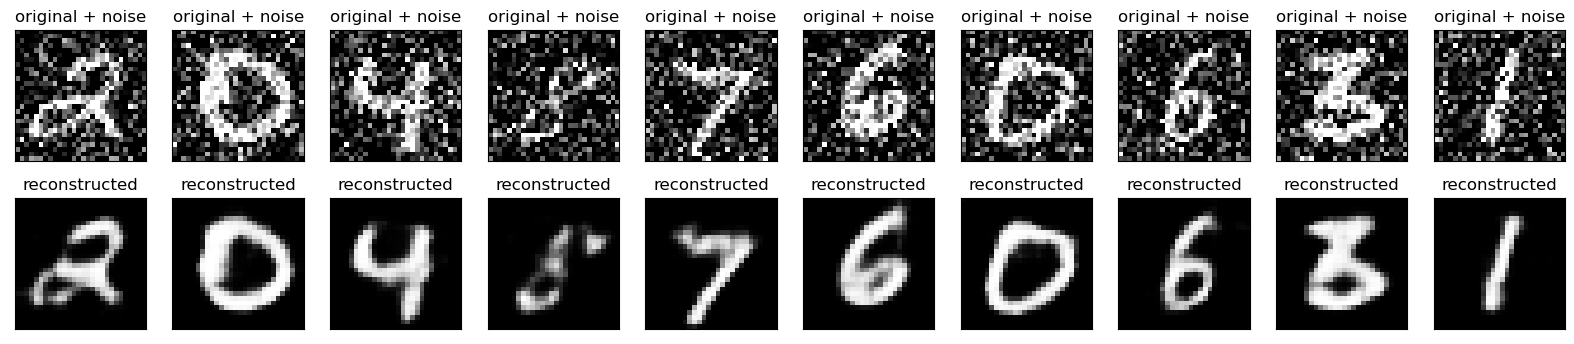

In [32]:
# assemble reconstructed imgs for visualization
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()